In [1]:
import csv
import math
import copy
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
# Function to predict the most likely outcome (binary string)
def predict_binary_string(predictions, num_qubits):
    # Get the index of the maximum probability
    max_index = torch.argmax(predictions).item()

    # Convert index to corresponding binary string
    result_string = bin(max_index)[2:].zfill(num_qubits)
    return result_string

In [3]:
# Function to calculate accuracy
def calculate_accuracy(predictions, ground_truth):
    correct = 0
    total = len(predictions)

    for predicted, true in zip(predictions, ground_truth):
        
        # Compare the predicted binary string with the true label
        if predicted == true:
            correct += 1

    accuracy = correct / total
    return accuracy

In [4]:
def plot_distribution(distribution, target=None, window=30):
    distribution = np.array(distribution)
    x = np.arange(len(distribution))

    if target is not None and 0 <= target < len(distribution):
        start = max(target - window // 2, 0)
        end = min(target + window // 2 + 1, len(distribution))
        x = x[start:end]
        distribution = distribution[start:end]
        colors = ['skyblue'] * len(distribution)
        colors[target - start] = 'red'
    else:
        colors = ['skyblue'] * len(distribution)

    plt.figure(figsize=(12, 5))
    plt.bar(x, distribution, color=colors)
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.title("Zoomed Distribution Around Target")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [5]:
def get_rank(data_dict, target):
    # Convert dict items to a list of (bit_string, value) pairs
    items = list(data_dict.items())
    # Sort by value in descending order
    sorted_items = sorted(items, key=lambda x: x[1], reverse=True)
    
    # Create a mapping from bit string to rank (1-based)
    rank_map = {bit: rank+1 for rank, (bit, _) in enumerate(sorted_items)}
    
    # Return the rank of the target bit string
    return rank_map.get(target, None)  # Returns None if target not in dict


In [6]:
def fid_class(dist_a, dist_b):
    """
    Calculate the fidelity between two probability distributions.

    Args:
        dist_a (list): The first probability distribution.
        dist_b (list): The second probability distribution.

    Returns:
        float: The fidelity between the two distributions.
    """
    fid = 0

    for a, b in zip(dist_a, dist_b):
        # Calculate the square root of the product of corresponding elements in the distributions
        fid += np.sqrt(a * b)
    return fid

In [7]:
def newResultDict(test_case):
    dict = {"secret_string":test_case}
    stringArray = ["0"] * len(test_case)
    string = "".join(stringArray)
    while(True):
        dict[string] = 0
        if(string == "1" * len(test_case)):
            break
        for i in range(len(string)):
            if string[i] == "0":
                if string[i+1:].find("0") == -1:
                    stringArray[i] = "1"
                    for v in range(i + 1, len(test_case)):
                        stringArray[v] = "0"
                    string = "".join(stringArray)
                    break
    return dict


In [8]:
def hamm_dist(x, y):
    if(len(x) != len(y)):
        return
    count = 0
    for i in range(len(x)):
        if(x[i] != y[i]):
            count += 1
    return count

In [9]:
def Hamm_Method(set):
    length = math.floor(n/2)
    CHS = [0.0] * length
    for x in set.keys():
        if x == "secret_string":
            continue
        for y in set.keys():
            if y == "secret_string":
                continue
            d = hamm_dist(x, y)
            if d < math.floor(n/2):
                CHS[d] += float(set[y])
    W = [0.0] * length
    for i in range(length):
        if CHS[i] > 0:
            W[i] = 1/CHS[i]
    result = newResultDict(set["secret_string"])
    for x in set.keys():
        if x == "secret_string":
            continue
        score = float(set[x])
        for y in set.keys():
            if y == "secret_string":
                continue
            d = hamm_dist(x, y)
            if d < math.floor(n/2) and float(set[x]) > float(set[y]):
                score += W[d] * float(set[y])
            result[x] = score * float(set[x])
    return result

In [10]:
def normalize(set):
    total = 0
    for x in set:
        if x == "secret_string":
            continue
        total += float(set[x])
    for x in set:
        if x == "secret_string":
            continue
        set[x] = float(set[x])/total
    return set

In [11]:
def dec_to_countsVec(decimal, n_qubits, n_shots):
    res = [0] * (2**n_qubits)
    res[decimal] = n_shots
    return res

Test Hammer code

In [76]:
n = 9 #set to length of strings in file
key_list = []
result_bank = []

filename = f"1_7-ones_9qubitsBV.csv" #set to file name

with open(filename, 'r', newline='') as csvfile:
    resultDict = newResultDict("0" * n)
    reader = csv.DictReader(csvfile, fieldnames = resultDict.keys())
    for row in reader:
        key_list.append(row['secret_string'])
        result_bank.append({k: int(v) for k, v in list(row.items())[1:]})

data_dicts = []
for i in range(len(key_list)):
    temp = {}
    temp["input"] = result_bank[i]
    temp["target"] = key_list[i]
    data_dicts.append(temp)

In [77]:
data_dicts = data_dicts[::-1]

In [78]:
rank_list_b4 = []
for i in range(len(data_dicts)):
    rank_list_b4.append(get_rank(data_dicts[i]["input"], data_dicts[i]["target"]))
rank_list_b4 = np.array(rank_list_b4)
rank_list_b4

array([ 1,  1,  1,  1,  1,  7,  2,  1,  1,  8,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, 30, 15, 11,  1, 19,  7,  2,  2, 29,  2, 15,  2,  1,
        1,  1,  1, 18, 13,  4,  1,  3,  5,  2,  1,  5,  1,  7,  1,  1,  1,
        1,  1, 50, 26,  1,  1,  3,  1,  2,  1,  3,  1,  5,  1,  1,  1,  1,
        1, 52,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       65,  1,  1,  1,  3,  1,  1,  1,  1,  1,  2,  1,  4,  1,  1,  1,  1,
        1,  1,  1,  9,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  4,  1,
        2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [79]:
X = []
y = []
for i in range(len(data_dicts)):
    X.append([j for j in data_dicts[i]['input'].values()])
    y.append(data_dicts[i]['target'])

X = np.array(X)
X = X / X.sum(axis=1, keepdims=True)  # Normalizing noisy counts to sum to 1
X_tensor = torch.tensor(X, dtype=torch.float32)
target_bits = copy.deepcopy(y)

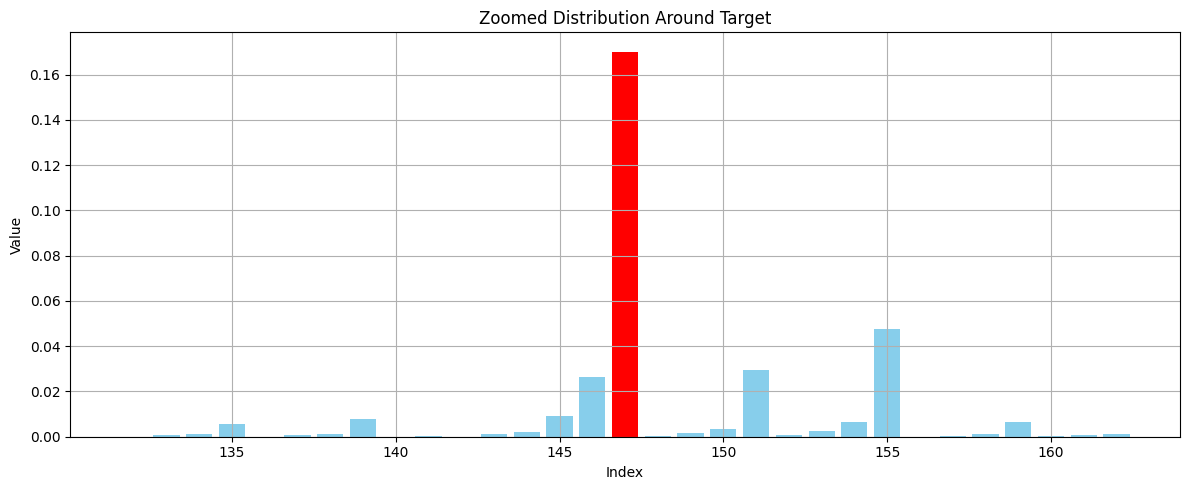

In [80]:
plot_distribution(X[1], int(y[1], 2))

In [81]:
original_predict = []
for i in range(len(X_tensor)):
    predicted_string = predict_binary_string(X_tensor[i], num_qubits=9)
    original_predict.append(predicted_string)
calculate_accuracy(original_predict, y)

0.7516778523489933

In [82]:
for i in range(len(y)):
    y[i] = dec_to_countsVec(int(y[i],2), n, 10240)

y = np.array(y)
y = y / y.sum(axis=1, keepdims=True)  # Normalizing ideal counts to sum to 1
y_tensor = torch.tensor(y, dtype=torch.float32)

In [83]:
pred = X_tensor.cpu().numpy()
true = y_tensor.cpu().numpy()
fidelities = [fid_class(p, t) for p, t in zip(pred, true)]

In [84]:
fidelities = np.array(fidelities)
average_fid = np.mean(fidelities)
average_fid

np.float32(0.5967754)

In [85]:
Hammer_results = []
with open(filename, 'r', newline='') as csvfile:
    resultDict = newResultDict("0" * n)
    reader = csv.DictReader(csvfile, fieldnames = resultDict.keys())
    for row in reader:
        resultDict = newResultDict("0" * n)
        for key in resultDict.keys():
            resultDict[key] = row[key]
        resultDict = normalize(resultDict)
        print("Before Hamming Method")
        rowAbbr = [(i, float(resultDict[i])) for i in resultDict.keys()] # in tuples to make it easier to sort
        rowAbbr.sort(key = lambda pair:(-pair[1], pair[0])) #sorting by number of shots first, and string order second
        origRank = 1
        found = False
        for i in rowAbbr[0:10]:
            if i[0] == "secret_string":
                print(i)
            else:
                print("    ", i) #indenting results to make it easier to tell where one test ends and another begins
                if(not found):
                    origRank += 1
                    if(i[0] == resultDict["secret_string"]):
                        found = True
        print("Rank:", origRank)
        #Hamming Method Time
        resultDict = newResultDict("0" * n)
        for key in resultDict.keys():
            resultDict[key] = row[key]
        resultDict = Hamm_Method(resultDict)
        resultDict = normalize(resultDict)
        print("After Hamming Method")
        rowAbbr = [(i, float(resultDict[i])) for i in resultDict.keys()] # in tuples to make it easier to sort
        rowAbbr.sort(key = lambda pair:(-pair[1], pair[0])) #sorting by number of shots first, and string order second
        hamRank = 1
        found = False
        for i in rowAbbr[0:10]:
            if i[0] == "secret_string":
                print(i)
            else:
                print("    ", i) #indenting results to make it easier to tell where one test ends and another begins
                if(not found):
                    hamRank += 1
                    if(i[0] == resultDict["secret_string"]):
                        found = True
        print("Rank:", hamRank)
        print("                Rank Improvement:", (hamRank - origRank))
        #Second Pass?
        resultDict = Hamm_Method(resultDict)
        resultDict = normalize(resultDict)
        print("After Hamming Method (2)")
        rowAbbr = [(i, float(resultDict[i])) for i in resultDict.keys()] # in tuples to make it easier to sort
        rowAbbr.sort(key = lambda pair:(-pair[1], pair[0])) #sorting by number of shots first, and string order second
        hamRank = 1
        found = False
        for i in rowAbbr[0:10]:
            if i[0] == "secret_string":
                print(i)
            else:
                print("    ", i) #indenting results to make it easier to tell where one test ends and another begins
                if(not found):
                    hamRank += 1
                    if(i[0] == resultDict["secret_string"]):
                        found = True
        print("Rank:", hamRank)
        print("                            Rank Improvement:", (hamRank - origRank))
        Hammer_results.append(resultDict)

Before Hamming Method
     ('000000000', 0.8541015625)
     ('000001000', 0.03818359375)
     ('000000001', 0.0337890625)
     ('000000010', 0.01298828125)
     ('010000000', 0.009765625)
     ('001000000', 0.00947265625)
     ('000100000', 0.009375)
     ('000010000', 0.00908203125)
     ('000000100', 0.00732421875)
     ('100000000', 0.00537109375)
Rank: 2
After Hamming Method
     ('000000000', 0.9956158396295011)
     ('000001000', 0.0019898909545802927)
     ('000000001', 0.0015582144558323788)
     ('000000010', 0.00023024009217019302)
     ('010000000', 0.0001301601887040645)
     ('001000000', 0.00012246741251289444)
     ('000100000', 0.00011995503697245099)
     ('000010000', 0.00011257479847026648)
     ('000000100', 7.321445925822683e-05)
     ('100000000', 3.937304855756547e-05)
Rank: 2
                Rank Improvement: 0
After Hamming Method (2)
     ('000000000', 0.9999932599005857)
     ('000001000', 4.126866850448729e-06)
     ('000000001', 2.4852103375085176e-06)
    

In [86]:
data_copy = copy.deepcopy(Hammer_results)
data_copy

[{'secret_string': '000000000',
  '000000000': 0.9999932599005857,
  '000000001': 2.4852103375085176e-06,
  '000000010': 5.735733076706852e-08,
  '000000011': 2.5062714509681915e-13,
  '000000100': 5.497340075041589e-09,
  '000000101': 1.4111314316136922e-14,
  '000000110': 0.0,
  '000000111': 0.0,
  '000001000': 4.126866850448729e-06,
  '000001001': 3.8605442301188966e-12,
  '000001010': 4.436404119449008e-13,
  '000001011': 1.7082267420832983e-16,
  '000001100': 2.3342232479150723e-13,
  '000001101': 0.0,
  '000001110': 1.7082267420832983e-16,
  '000001111': 0.0,
  '000010000': 1.3167015236072883e-08,
  '000010001': 1.1183371890553555e-13,
  '000010010': 2.977251151326822e-15,
  '000010011': 0.0,
  '000010100': 1.7082267420832983e-16,
  '000010101': 0.0,
  '000010110': 0.0,
  '000010111': 0.0,
  '000011000': 2.6118122956159877e-12,
  '000011001': 2.822676855774122e-15,
  '000011010': 0.0,
  '000011011': 0.0,
  '000011100': 0.0,
  '000011101': 0.0,
  '000011110': 0.0,
  '000011111': 0

In [87]:
Hammer_data_dicts = []
for i in data_copy:
    temp = {}
    temp['target'] = i['secret_string']
    i.pop('secret_string')
    temp['input'] = i
    Hammer_data_dicts.append(temp)

In [88]:
Hammer_data_dicts = Hammer_data_dicts[::-1]
Hammer_data_dicts

[{'target': '010010100',
  'input': {'000000000': 6.62325014927781e-09,
   '000000001': 4.448296087148814e-16,
   '000000010': 9.355820333473961e-15,
   '000000011': 0.0,
   '000000100': 2.992121748281066e-09,
   '000000101': 8.22603933336532e-15,
   '000000110': 4.1641364508923554e-14,
   '000000111': 0.0,
   '000001000': 1.1475706641454681e-12,
   '000001001': 0.0,
   '000001010': 0.0,
   '000001011': 0.0,
   '000001100': 7.646968822882954e-15,
   '000001101': 0.0,
   '000001110': 0.0,
   '000001111': 0.0,
   '000010000': 2.8524716130165507e-10,
   '000010001': 8.162512778013573e-15,
   '000010010': 4.448296087148814e-16,
   '000010011': 0.0,
   '000010100': 1.8281697270355105e-05,
   '000010101': 9.135054507350946e-11,
   '000010110': 3.0840520788168277e-10,
   '000010111': 7.406881407649311e-15,
   '000011000': 1.2209897361286963e-13,
   '000011001': 0.0,
   '000011010': 0.0,
   '000011011': 0.0,
   '000011100': 4.143521951691779e-10,
   '000011101': 4.0115439673163136e-14,
   '000

In [89]:
X = []
y = []
for i in range(len(Hammer_data_dicts)):
    X.append([j for j in Hammer_data_dicts[i]['input'].values()])
    y.append(Hammer_data_dicts[i]['target'])

X = np.array(X)
X = X / X.sum(axis=1, keepdims=True)  # Normalizing noisy counts to sum to 1
X_tensor = torch.tensor(X, dtype=torch.float32)

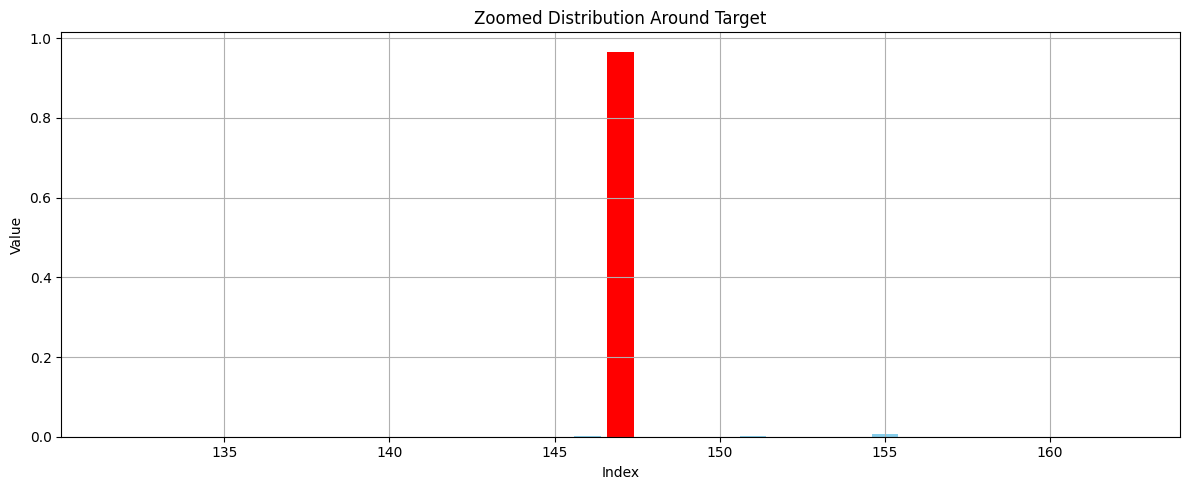

In [90]:
plot_distribution(X[1], int(y[1], 2))

In [91]:
Hammer_predict = []
for i in range(len(X_tensor)):
    predicted_string = predict_binary_string(X_tensor[i], num_qubits=9)
    Hammer_predict.append(predicted_string)
calculate_accuracy(Hammer_predict, y)

0.7516778523489933

In [92]:
rank_list_after = []
for i in range(len(Hammer_data_dicts)):
    rank_list_after.append(get_rank(Hammer_data_dicts[i]["input"], Hammer_data_dicts[i]["target"]))
rank_list_after = np.array(rank_list_after)
rank_list_after

array([ 1,  1,  1,  1,  1,  7,  2,  1,  1,  8,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, 29, 16, 12,  1, 19,  7,  2,  2, 29,  2, 15,  2,  1,
        1,  1,  1, 18, 13,  4,  1,  3,  5,  2,  1,  5,  1,  7,  1,  1,  1,
        1,  1, 50, 25,  1,  1,  3,  1,  2,  1,  3,  1,  5,  1,  1,  1,  1,
        1, 53,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       66,  1,  1,  1,  3,  1,  1,  1,  1,  1,  2,  1,  5,  1,  1,  1,  1,
        1,  1,  1,  9,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  4,  1,
        2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [93]:
increase = 0
decrease = 0
for i in range(len(rank_list_b4)):
    if rank_list_b4[i] < rank_list_after[i]:
        decrease += 1
    if rank_list_b4[i] > rank_list_after[i]:
        increase += 1
increase, decrease

(2, 5)

In [94]:
for i in range(len(y)):
    y[i] = dec_to_countsVec(int(y[i],2), n, 10240)

y = np.array(y)
y = y / y.sum(axis=1, keepdims=True)  # Normalizing ideal counts to sum to 1
y_tensor = torch.tensor(y, dtype=torch.float32)

In [95]:
pred = X_tensor.cpu().numpy()
true = y_tensor.cpu().numpy()
fidelities = [fid_class(p, t) for p, t in zip(pred, true)]

In [96]:
fidelities = np.array(fidelities)
average_fid = np.mean(fidelities)
average_fid

np.float32(0.7802363)